In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

import numpy as np
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import time
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
wandb.init(project="faceMask_detection")

In [6]:
train_dataset_path = "Face Mask Dataset\Train"
val_dataset_path = "Face Mask Dataset\Validation"
width = height = 224
batch_size = 32

idg = ImageDataGenerator(
    rescale = 1./255,
    
    #Augmentation
    horizontal_flip = True,
    brightness_range = (0.8, 1.2),
    rotation_range = 10,
    shear_range = 0.2,
    zoom_range = 0.1
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical"
)

val_data = idg.flow_from_directory(
    val_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


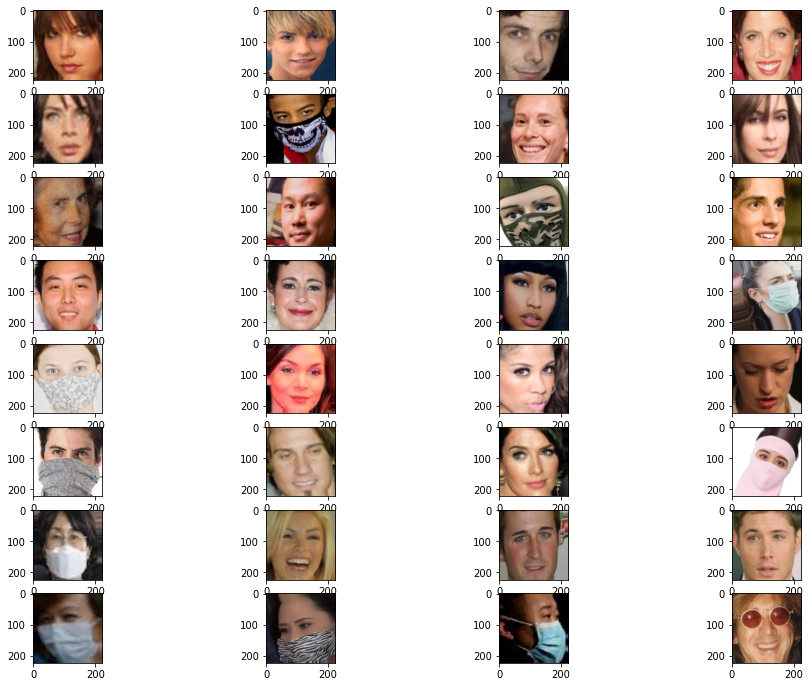

In [16]:
X, _ = next(train_data)
plt.figure(figsize=(16, 12))
for i in range(batch_size):
    plt.subplot(8, 4, i+1)
    plt.imshow(X[i])

### Model

In [30]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(width, height, 3),
    include_top=False,
    weights="imagenet",
    pooling="avg",
)

In [31]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
base_model.summary()

In [32]:
model = tf.keras.models.Sequential([
    base_model,
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(2, activation="softmax")
])

In [33]:
config = wandb.config
config.learning_rate = 0.001

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [35]:
model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[WandbCallback()])

Epoch 1/10
313/313 [==============================] - 189s 599ms/step - loss: 0.0567 - accuracy: 0.9814 - val_loss: 0.2450 - val_accuracy: 0.9500 - _timestamp: 1647653124.0000 - _runtime: 237.0000
Epoch 2/10
313/313 [==============================] - 159s 507ms/step - loss: 0.0213 - accuracy: 0.9927 - val_loss: 0.0080 - val_accuracy: 0.9950 - _timestamp: 1647653283.0000 - _runtime: 396.0000
Epoch 3/10
313/313 [==============================] - 160s 512ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.0334 - val_accuracy: 0.9900 - _timestamp: 1647653444.0000 - _runtime: 557.0000
Epoch 4/10
313/313 [==============================] - 157s 502ms/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.0044 - val_accuracy: 0.9975 - _timestamp: 1647653601.0000 - _runtime: 714.0000
Epoch 5/10
313/313 [==============================] - 158s 504ms/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.0060 - val_accuracy: 0.9975 - _timestamp: 1647653759.0000 - _runtime: 872.0000
Epoch 6/10
313/

In [36]:
test_dataset_path = "Face Mask Dataset\Test"

idg = ImageDataGenerator(
    rescale = 1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 992 images belonging to 2 classes.


In [37]:
model.evaluate(test_data)

31/31 [==============================] - 9s 300ms/step - loss: 0.0061 - accuracy: 0.9980


[0.006071040406823158, 0.9979838728904724]

### Calculate Response Time

In [53]:
test_file_path = test_data.filepaths
rand_img_path = random.choice(test_file_path)

img = cv2.imread(rand_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (width, height))
img = img.reshape(1, width, height, 3) # 3d ---> 4d
img = img / 255.0

start_time = time.time()
model.predict(img)
end_time = time.time()
print(f"Response Time: {end_time - start_time}")

Response Time: 0.04303741455078125


### Confusion Matrix

In [66]:
Y_true = test_data.classes
Y_pred = []
for path in test_file_path:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img = img.reshape(1, width, height, 3) # 3d ---> 4d
    img = img / 255.0
    y_pred = np.argmax(model.predict(img))
    Y_pred.append(y_pred)

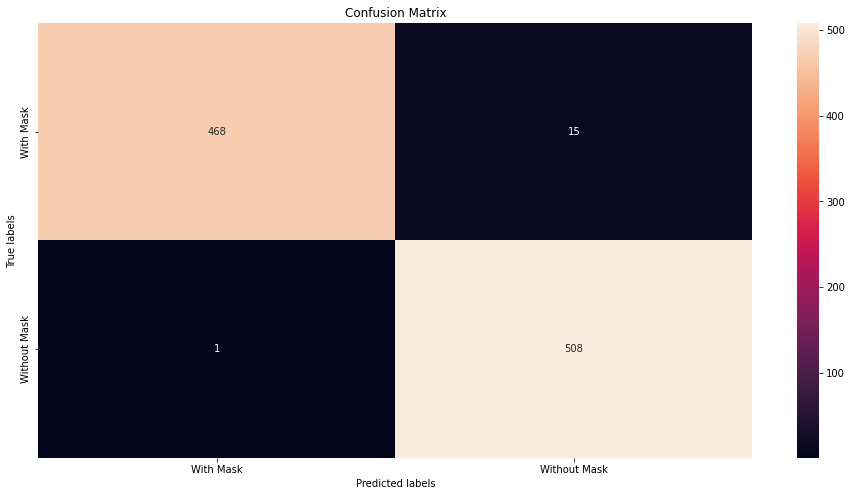

In [81]:
conf_mat = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(16, 8))
ax = sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(["With Mask", "Without Mask"])
ax.yaxis.set_ticklabels(["With Mask","Without Mask"])
plt.show()

### Save model

In [78]:
model.save("model/faceMask_detection.h5")